# 🎓 **Taller 4.5.2: Taller de Métodos de Clustering Jerarquico**


## OBJETIVOS DEL TALLER:
En esta práctica vamos a ver cómo funcionan los algoritmos jerárquicos vistos en clase: el aglomerativo y el divisivo.

# 🔧 **CONFIGURACIÓN INICIAL**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools as it
from matplotlib.cm import get_cmap
from scipy.cluster.hierarchy import dendrogram

plt.rcParams['figure.figsize'] = [8, 8]

# 📁 **CARGAR LOS DATASETS Y GRAFICAR SUS DISTRIBUCIONES**

In [2]:
# Cargar dataset artificial
def cargar_dataset(nombre_dataset):
    try:
        # Intentar cargar desde URL alternativa
        data_file_url = "https://raw.githubusercontent.com/SandraNavarrete-docente/aprendizaje-automatico-252601/main/04-MODELOS-NO-SUPERVISADOS/data/"+nombre_dataset
        D = np.array(pd.read_excel(data_file_url,header=0))
        print("✅ Dataset cargado desde URL GitHub")
        return D
    except:
        print("❌ No se pudo cargar el dataset")
        return None

def cargar_dataset_csv(nombre_dataset):
    try:
        # Intentar cargar desde URL alternativa
        data_file_url = "https://raw.githubusercontent.com/SandraNavarrete-docente/aprendizaje-automatico-252601/main/04-MODELOS-NO-SUPERVISADOS/data/"+nombre_dataset
        D = np.array(pd.read_csv(data_file_url,header=0))
        print("✅ Dataset cargado desde URL GitHub")
        return D
    except:
        print("❌ No se pudo cargar el dataset")
        return None

✅ Dataset cargado desde URL GitHub


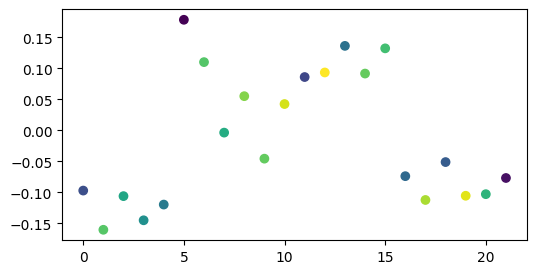

In [3]:
# Cargar dataset
D =cargar_dataset("dataset_reducido.xlsx")
Dx = D[:,0:2]
Dx = Dx[ np.random.choice(np.arange(Dx.shape[0]), Dx.shape[0], replace=False) ,:]
Dy = D[:,2]
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dy)

# Incluimos una serie de funciones que nos van a permitir visualizar los resultados.

In [4]:
def plot_particiones_grid(Dx, mParticiones, figsize=(15, 10)):

    n_partitions = mParticiones.shape[1] -1
    # Calcular distribución de subplots
    cols = min(4, n_partitions)  # Máximo 4 columnas
    rows = (n_partitions + cols - 1) // cols  # Redondeo hacia arriba

    fig, axes = plt.subplots(rows, cols, figsize=figsize, squeeze=False)
    fig.suptitle('Particiones Jerárquicas Aglomerativas', fontsize=16, fontweight='bold')

    # Obtener colormap una sola vez
    cmap = plt.colormaps['tab20']
    n_samples = Dx.shape[0]
    vals = np.linspace(0, 1, n_samples + 2)[1:-1]
    rgba = cmap(vals)

    for k in range(n_partitions):
        row = k // cols
        col = k % cols
        ax = axes[row, col]

        # Obtener etiquetas de cluster para esta partición
        labels = mParticiones[:, k]

        # Crear scatter plot
        scatter = ax.scatter(Dx[:, 0], Dx[:, 1],
                            c=rgba[labels],
                            s=50, alpha=0.8, edgecolors='w', linewidth=0.5)

        ax.set_title(f'K = {k+1} clusters', fontsize=11)
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.grid(True, alpha=0.3, linestyle='--')

    # Ocultar ejes vacíos si hay menos subplots que celdas
    for k in range(n_partitions, rows * cols):
        row = k // cols
        col = k % cols
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.93)  # Ajustar para el título
    return fig, axes

In [5]:
# Muestra los ejemplos coloreados según su pertenencia a los clústeres
# K indica el número de clústeres a mostrar a partir de la jerarquía
def plot_particion_K(Dx, mParticiones,K):
  # Nueva sintaxis para obtener colormaps
    cmap = plt.colormaps['tab20']
    n_samples = Dx.shape[0]
    vals = np.linspace(0, 1, n_samples + 2)[1:-1]  # Más eficiente
    rgba = cmap(vals)
    # Crear gráfico
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.scatter(Dx[:, 0], Dx[:, 1],
               c=rgba[mParticiones[:, K-1]],  # Nota: no necesita el último ":"
               s=60, alpha=0.8)
    return fig, ax

# Muestra el dendrograma de la jerarquía
def plot_dendrograma_de_mparticiones(mD, mParticiones):
    nPasos = mD.shape[0]-1
    distancias = np.zeros(nPasos)
    tamanyos = np.zeros(nPasos)
    uniones = np.zeros(2*nPasos,dtype=np.int8)
    uniones.shape=(nPasos,2)

    mNParticiones = mParticiones.copy()
    for n in np.arange(mNParticiones.shape[0]):
        valor = mParticiones[n,mNParticiones.shape[1]-1]
        mNParticiones[mParticiones==valor] = n

    k = 0
    aux = np.array(range(mNParticiones.shape[1]-1))
    for n in aux[::-1]:
        # cual es el diferente?
        prim_diferencia = np.where(mParticiones[:,n]!=mParticiones[:,n+1])[0][0]
        submatriz = mNParticiones[:,:n+1]
        submatriz[submatriz==mNParticiones[prim_diferencia,n]] = mNParticiones.shape[1]+k
        mNParticiones[:,:n+1] = submatriz
        uniones[k,:] = np.unique(mNParticiones[mNParticiones[:,n]==mNParticiones.shape[1]+k,n+1])
        tamanyos[k] = np.sum(mNParticiones[:,n]==mNParticiones.shape[1]+k)

        vs = mNParticiones[:,n+1]
        distancias[k] = 1 / (2 * tamanyos[k]) * (
            np.sum(mD[ np.ix_(np.where(vs == uniones[k,0])[0],
                              np.where(vs == uniones[k,1])[0])])+
            np.sum(mD[ np.ix_(np.where(vs == uniones[k,1])[0],
                              np.where(vs == uniones[k,0])[0])]))
        k += 1

    distancias = np.arange(uniones.shape[0])
    # Creamos la matriz de enlaces que necesita el método dendrogram de scipy
    mEnlaces = np.column_stack([uniones, distancias, tamanyos]).astype(float)

    plt.figure(figsize=(15, 8))
    plt.title('Dendrograma de Clustering Jerárquico')
    plt.xlabel('Índice del caso')
    plt.ylabel('Distancia')
    dendrogram(mEnlaces)
    plt.show()

# 🎯 **1:Cree el Algoritmo de Clustering Divisivo (TOP-DOWN)**

##Calcular la matriz de distancias del dataset.

In [6]:
def distancia_euclidiana(x, y):
    return np.sqrt(np.sum((x-y)**2))

def matriz_distancias(X, distancia):
    mD = np.zeros((X.shape[0],X.shape[0]))
    for pair in it.product(np.arange(X.shape[0]), repeat=2):
        mD[pair] = distancia(X[pair[0],:],X[pair[1],:])
    return mD

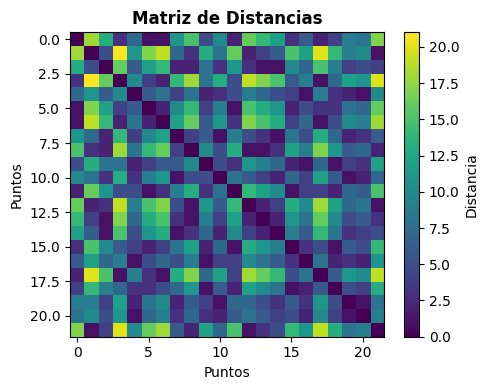

In [33]:
mD = matriz_distancias(Dx, distancia_euclidiana) # P1 Complete su codigo aqui
plt.figure(figsize=(5, 4))
plt.imshow(mD, cmap='viridis', vmin=mD.min(), vmax=mD.max(), aspect='auto')
plt.colorbar(label='Distancia')
plt.title('Matriz de Distancias', fontweight='bold')
plt.xlabel('Puntos')
plt.ylabel('Puntos')
plt.tight_layout()
plt.show()

## Crear el algoritmo Divisivo

In [34]:
def clustering_divisivo(mD, disimilitud_intracluster, separador, imprimir, **kwargs):
    # En esta matriz almacenaremos las sucesivas particiones (clusterings) de los
    # datos. Sucesivas, porque cada paso del bucle de abajo realizará una separación
    # entre los dos clusters más diferentes, hasta que haya un cluster por elemento
    # del dataset.
    mParticiones = np.zeros((mD.shape[0], mD.shape[0]), dtype = np.int64)
    # Recorremos `mParticiones` (en esta ocasión, de manera creciente) guardando
    # los agrupamientos
    for n in range(1, mParticiones.shape[1]):
        if imprimir:
          print(f'Paso número {n}')
        # Al empezar, asignamos el agrupamiento anterior al actual, ya que el
        # agrupamiento en el momento anterior (`n-1`) únicamente sufrirá alguna
        # modificación para dividir los dos clusters más separados.
        mParticiones[:,n] = mParticiones[:,n-1]
        # Calculamos la disimilitud intracluster
        rDisIntraCluster = disimilitud_intracluster(mD, mParticiones[:, n-1], n)
        # Y escogemos el cluster en el que mayor sea la disimilitud
        iClusterADiv = np.argmax(rDisIntraCluster)
        if imprimir:
          print(f'Cluster a dividir: {iClusterADiv}')
        # Separamos dicho cluster en 2 sub-clusters siguiendo el criterio escogido
        iAClusterNuevo = separador(mD, mParticiones[:, n-1], iClusterADiv, **kwargs)
        if imprimir:
          print(f'Número de elementos a asignar al nuevo cluster {n}: {len(iAClusterNuevo)}')
        mParticiones[iAClusterNuevo, n] = n
    return mParticiones

### Funciones para calcular la disimilitud intraclúster

In [35]:
def disimilitud_diametro(mD, particion, n):
    res = [ np.max((mD[ np.ix_(particion == pn , particion == pn) ] +
                    np.transpose(mD[ np.ix_(particion == pn , particion == pn) ]))/ 2)
           for pn in np.arange(n)]
    return res

In [36]:
def disimilitud_media(mD, particion, n):
    res = [np.sum(mD[ np.ix_(particion == pn , particion == pn) ])
                              / (np.sum(particion == pn)**2)
                              for pn in np.arange(n)]
    return res

### Criterios para separar un cluster

In [37]:
def separacion_macnaughton_smith(mDglobal, particion, iCluster):
    indsClust = np.where(particion==iCluster)[0]
    mD = mDglobal[ np.ix_(indsClust , indsClust)]

    SA = np.array([np.argmax(1/((mD.shape[0]-1)*2)*(np.sum(mD,axis=0)+np.sum(mD,axis=1)))])
    SB = np.delete(np.arange(mD.shape[0]), SA)
    if (SB.size == 1):
        return indsClust[SA]
    while True:
        res = np.zeros(SB.size)
        # Para todos los elementos del cluster original SB
        for i in np.arange(SB.size):
            SBa = np.delete(SB,i)
            res[i] = (# distancia media con los otros elementos de SB
                np.sum(mD[ SB[i] , SBa ]) +
                np.sum(mD[ SBa , SB[i] ])
            ) / (2 * SBa.size) - (# distancia media con los elementos ya movidos a SA
                np.sum(mD[ SB[i] , SA ]) +
                np.sum(mD[ SA , SB[i] ])
            ) / (2 * SA.size)
        # Si en todos los casos (todas las posiciones del vector res) la distancia
        # es negativa quiere decir que no existe ningún elemento en SB más cercano
        # a SA que al resto de SB
        if np.all(res < 0):
            break
        iToChange = np.argmax(res)
        SA = np.sort(np.append(SA, SB[iToChange]))
        SB = np.delete(np.arange(mD.shape[0]), SA)
    # Devolveremos los índices de los elementos que pertenecerán al clúster SA
    return indsClust[SA]

In [38]:
from sklearn.cluster import KMeans

def separacion_Kmeans(mDglobal, particion, iCluster, Dxglobal):
    indsClust = np.where(particion==iCluster)[0]
    Dx = Dxglobal[indsClust,:]
    modelo = KMeans(n_clusters=2, random_state=0, n_init=10)
    modelo = modelo.fit(Dx)
    Dyp = modelo.labels_
    # Devolveremos los índices de los ejemplos asignados
    # al segundo clúster
    return indsClust[Dyp==1]

## Ahora ya estamos en disposición de realizar el clustering jerárquico divisivo.
*   Usar el criterio de disimilitud media y diámetro en combinación con la separación de Macnaughton-Smith y la de K-means
*   Mostrar (plotear) las respectivas particiones con 5 clústeres.

In [39]:

# Usando disimilitud media y el método de separacion de Macnaughton-Smith
mParticiones = clustering_divisivo(mD, disimilitud_media, separacion_macnaughton_smith, True)

Paso número 1
Cluster a dividir: 0
Número de elementos a asignar al nuevo cluster 1: 11
Paso número 2
Cluster a dividir: 1
Número de elementos a asignar al nuevo cluster 2: 5
Paso número 3
Cluster a dividir: 0
Número de elementos a asignar al nuevo cluster 3: 5
Paso número 4
Cluster a dividir: 1
Número de elementos a asignar al nuevo cluster 4: 3
Paso número 5
Cluster a dividir: 0
Número de elementos a asignar al nuevo cluster 5: 3
Paso número 6
Cluster a dividir: 2
Número de elementos a asignar al nuevo cluster 6: 2
Paso número 7
Cluster a dividir: 3
Número de elementos a asignar al nuevo cluster 7: 3
Paso número 8
Cluster a dividir: 4
Número de elementos a asignar al nuevo cluster 8: 1
Paso número 9
Cluster a dividir: 1
Número de elementos a asignar al nuevo cluster 9: 1
Paso número 10
Cluster a dividir: 5
Número de elementos a asignar al nuevo cluster 10: 1
Paso número 11
Cluster a dividir: 7
Número de elementos a asignar al nuevo cluster 11: 1
Paso número 12
Cluster a dividir: 2
Nú

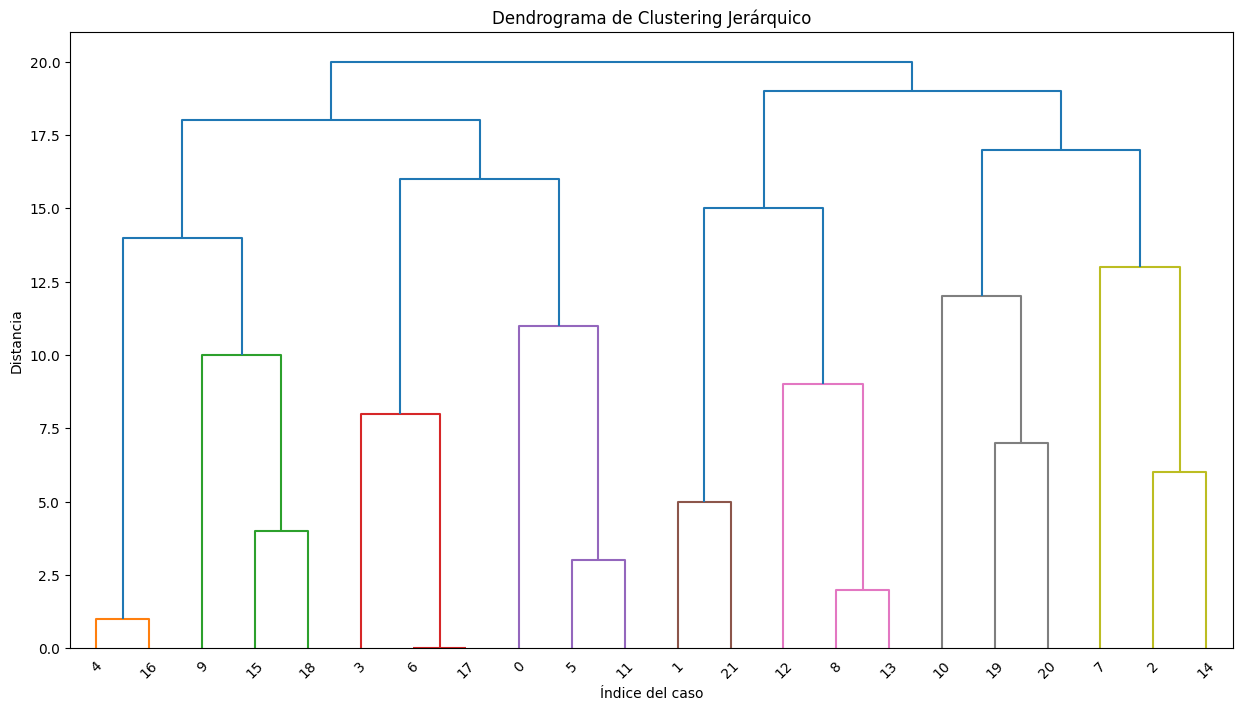

In [40]:
plot_dendrograma_de_mparticiones(mD, mParticiones)

(<Figure size 1000x500 with 1 Axes>, <Axes: >)

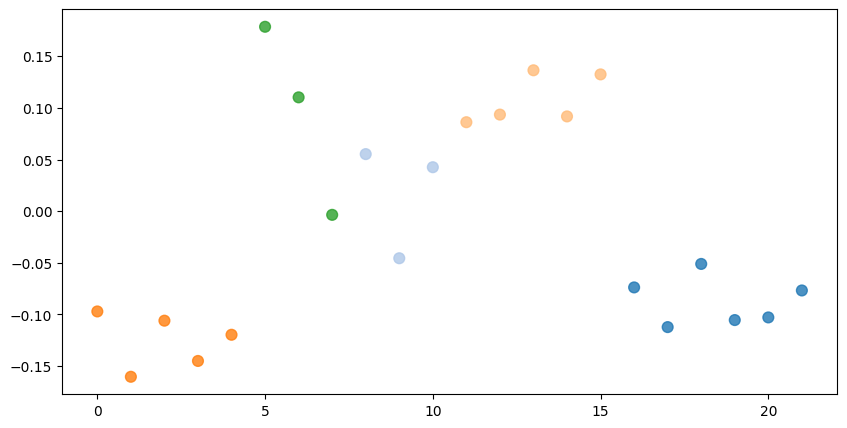

In [41]:
K = 5 # parametro para mostrar una particion
plot_particion_K(Dx, mParticiones, K)

In [42]:
mParticiones = clustering_divisivo(mD, disimilitud_diametro, separacion_macnaughton_smith, True)

Paso número 1
Cluster a dividir: 0
Número de elementos a asignar al nuevo cluster 1: 11
Paso número 2
Cluster a dividir: 0
Número de elementos a asignar al nuevo cluster 2: 5
Paso número 3
Cluster a dividir: 1
Número de elementos a asignar al nuevo cluster 3: 5
Paso número 4
Cluster a dividir: 1
Número de elementos a asignar al nuevo cluster 4: 3
Paso número 5
Cluster a dividir: 0
Número de elementos a asignar al nuevo cluster 5: 3
Paso número 6
Cluster a dividir: 2
Número de elementos a asignar al nuevo cluster 6: 3
Paso número 7
Cluster a dividir: 3
Número de elementos a asignar al nuevo cluster 7: 2
Paso número 8
Cluster a dividir: 4
Número de elementos a asignar al nuevo cluster 8: 1
Paso número 9
Cluster a dividir: 0
Número de elementos a asignar al nuevo cluster 9: 1
Paso número 10
Cluster a dividir: 5
Número de elementos a asignar al nuevo cluster 10: 1
Paso número 11
Cluster a dividir: 3
Número de elementos a asignar al nuevo cluster 11: 1
Paso número 12
Cluster a dividir: 1
Nú

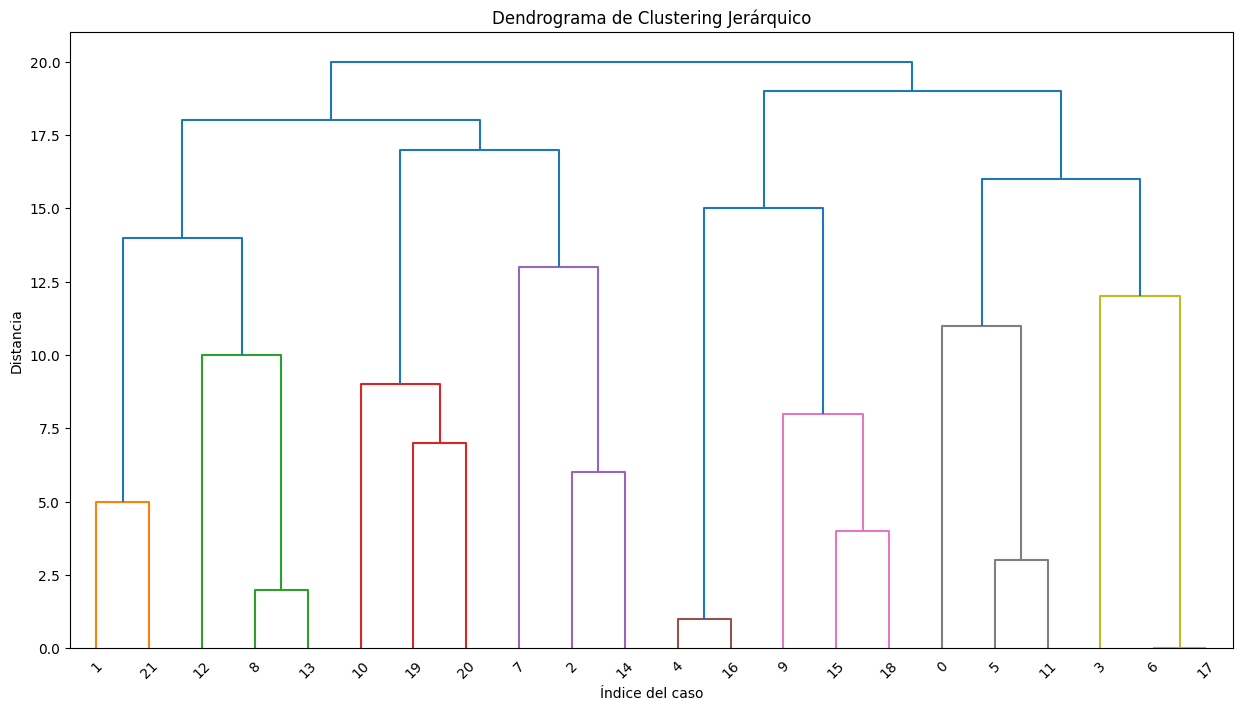

In [43]:
plot_dendrograma_de_mparticiones(mD, mParticiones)

(<Figure size 1000x500 with 1 Axes>, <Axes: >)

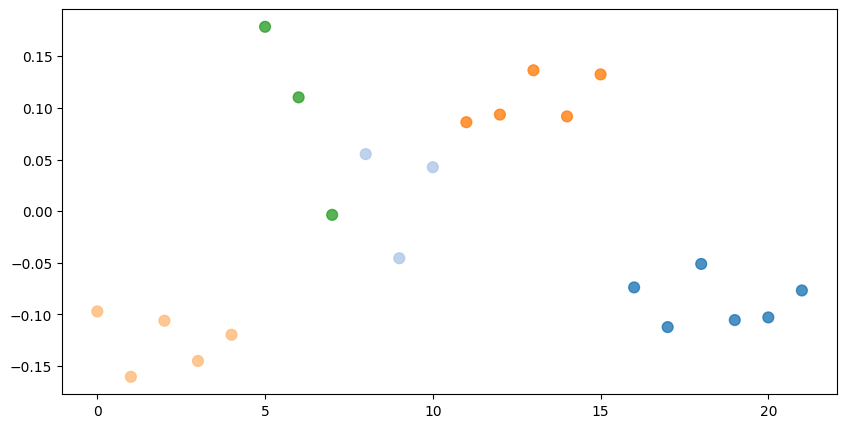

In [44]:
plot_particion_K(Dx, mParticiones, K)

In [45]:
# Usando disimilitud media y K-means como método de separacion
mParticiones = clustering_divisivo(mD, disimilitud_media, separacion_Kmeans, True, Dxglobal=Dx)

Paso número 1
Cluster a dividir: 0
Número de elementos a asignar al nuevo cluster 1: 11
Paso número 2
Cluster a dividir: 1
Número de elementos a asignar al nuevo cluster 2: 5
Paso número 3
Cluster a dividir: 0
Número de elementos a asignar al nuevo cluster 3: 5
Paso número 4
Cluster a dividir: 1
Número de elementos a asignar al nuevo cluster 4: 3
Paso número 5
Cluster a dividir: 0
Número de elementos a asignar al nuevo cluster 5: 3
Paso número 6
Cluster a dividir: 2
Número de elementos a asignar al nuevo cluster 6: 2
Paso número 7
Cluster a dividir: 3
Número de elementos a asignar al nuevo cluster 7: 2
Paso número 8
Cluster a dividir: 1
Número de elementos a asignar al nuevo cluster 8: 2
Paso número 9
Cluster a dividir: 4
Número de elementos a asignar al nuevo cluster 9: 1
Paso número 10
Cluster a dividir: 2
Número de elementos a asignar al nuevo cluster 10: 1
Paso número 11
Cluster a dividir: 0
Número de elementos a asignar al nuevo cluster 11: 1
Paso número 12
Cluster a dividir: 3
Nú

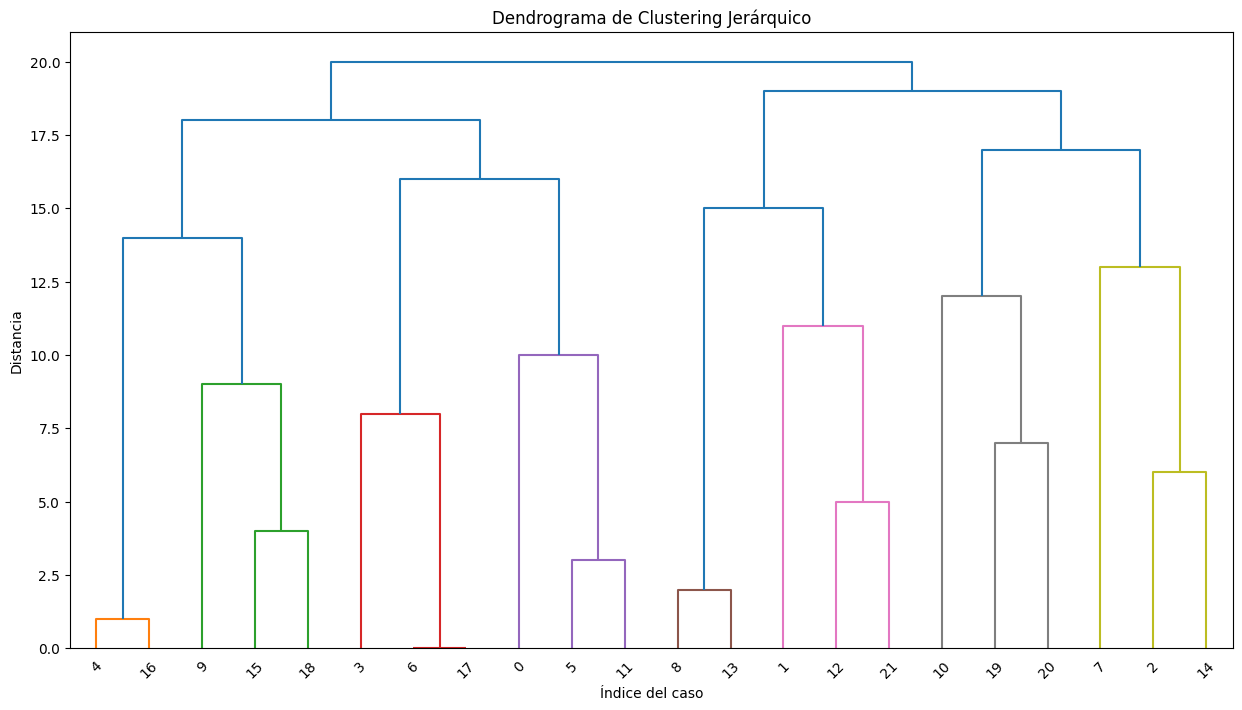

In [46]:
plot_dendrograma_de_mparticiones(mD, mParticiones)

(<Figure size 1000x500 with 1 Axes>, <Axes: >)

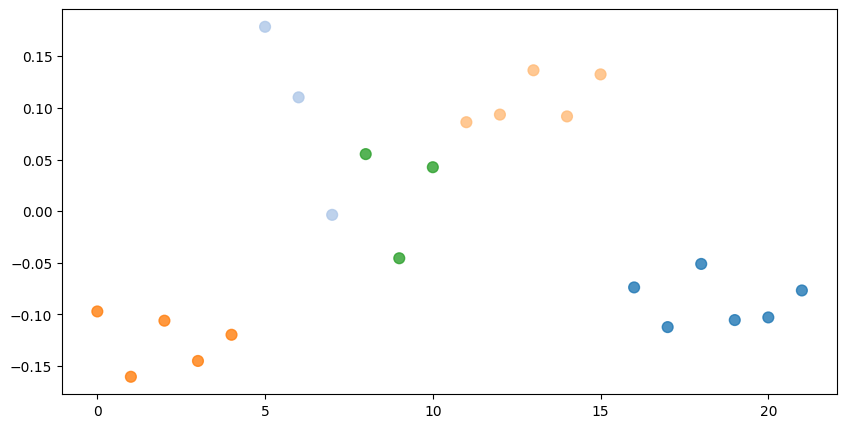

In [47]:
plot_particion_K(Dx, mParticiones, K)

In [48]:
# Usando disimilitud diámetro y K-means como método de separacion
mParticiones = clustering_divisivo(mD, disimilitud_diametro, separacion_Kmeans, True, Dxglobal=Dx)

Paso número 1
Cluster a dividir: 0
Número de elementos a asignar al nuevo cluster 1: 11
Paso número 2
Cluster a dividir: 0
Número de elementos a asignar al nuevo cluster 2: 5
Paso número 3
Cluster a dividir: 1
Número de elementos a asignar al nuevo cluster 3: 5
Paso número 4
Cluster a dividir: 1
Número de elementos a asignar al nuevo cluster 4: 3
Paso número 5
Cluster a dividir: 0
Número de elementos a asignar al nuevo cluster 5: 3
Paso número 6
Cluster a dividir: 2
Número de elementos a asignar al nuevo cluster 6: 2
Paso número 7
Cluster a dividir: 3
Número de elementos a asignar al nuevo cluster 7: 2
Paso número 8
Cluster a dividir: 1
Número de elementos a asignar al nuevo cluster 8: 2
Paso número 9
Cluster a dividir: 5
Número de elementos a asignar al nuevo cluster 9: 1
Paso número 10
Cluster a dividir: 0
Número de elementos a asignar al nuevo cluster 10: 1
Paso número 11
Cluster a dividir: 4
Número de elementos a asignar al nuevo cluster 11: 1
Paso número 12
Cluster a dividir: 3
Nú

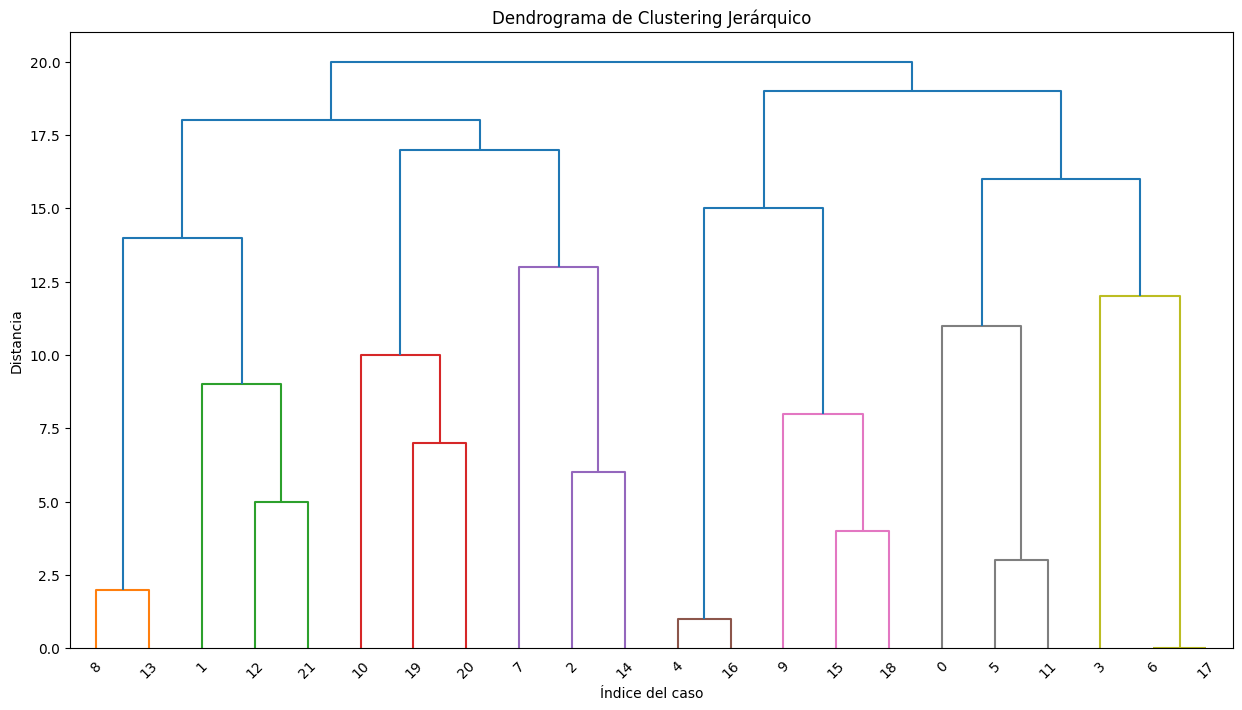

In [49]:
plot_dendrograma_de_mparticiones(mD, mParticiones)

(<Figure size 1000x500 with 1 Axes>, <Axes: >)

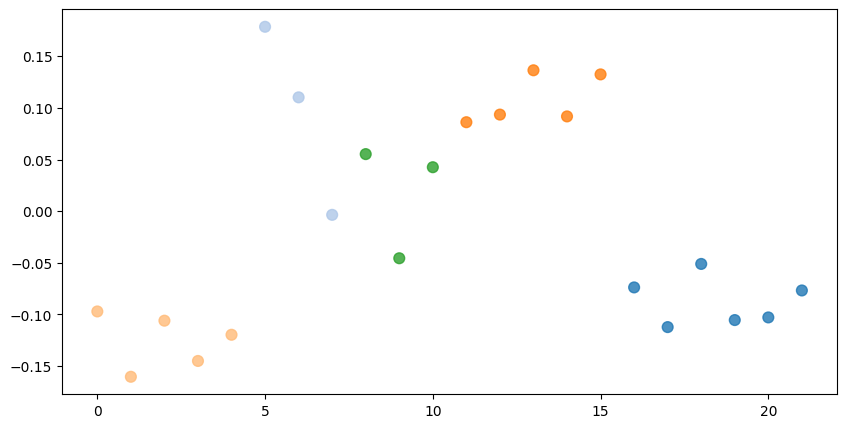

In [50]:
plot_particion_K(Dx, mParticiones, K)

<hr>
<h2>Implementaciones en librerías de Python</h2>

Dada la complejidad añadida del clustering jerárquico divisivo (respecto al aglomerativo), las principales librarías de aprendizaje automático de Python <b>no implementan</b> esta versión del agrupamiento jerárquico.

# 🎯 **EJ 2: Podemos hacer unas pruebas para ganar algunas intuiciones sobre cuál es la mejor estrategia según el tipo de datos...**



In [71]:
import matplotlib.pyplot as plt
def plot_varios(Dx, Dy, K):
    cmap = plt.colormaps['tab20']
    n_samples = Dx.shape[0]
    vals = np.linspace(0, 1, n_samples + 2)[1:-1]
    rgba = cmap(vals)

    # K here is the number of desired clusters, so we access K-1 index for the partition matrix
    k_index = K - 1

    fig, ax = plt.subplots(1, 5, figsize=(20, 5))

    # Gráfico 1: Datos originales
    ax[0].scatter(Dx[:, 0], Dx[:, 1], c=Dy)
    ax[0].set_title('Datos originales (Etiquetas Verdaderas)')

    mD = matriz_distancias(Dx, distancia_euclidiana)

    # Gráfico 2: Disimilitud media y Macnaughton-Smith
    mParticiones_ms_media = clustering_divisivo(mD, disimilitud_media, separacion_macnaughton_smith, False)
    dy2_ms_media = mParticiones_ms_media[:, k_index]
    ax[1].scatter(Dx[:, 0], Dx[:, 1], c=rgba[dy2_ms_media], s=50, alpha=0.8, edgecolors='w', linewidth=0.5)
    ax[1].set_title('Disimilitud media y Macnaughton-Smith (K='+str(K)+')')

    # Gráfico 3: Disimilitud media y Kmeans
    mParticiones_kmeans_media = clustering_divisivo(mD, disimilitud_media, separacion_Kmeans, False, Dxglobal=Dx)
    dy2_kmeans_media = mParticiones_kmeans_media[:, k_index]
    ax[2].scatter(Dx[:, 0], Dx[:, 1], c=rgba[dy2_kmeans_media], s=50, alpha=0.8, edgecolors='w', linewidth=0.5)
    ax[2].set_title('Disimilitud media y Kmeans (K='+str(K)+')')

    # Gráfico 4: Disimilitud diametro y Macnaughton-Smith
    mParticiones_ms_diametro = clustering_divisivo(mD, disimilitud_diametro, separacion_macnaughton_smith, False)
    dy2_ms_diametro = mParticiones_ms_diametro[:, k_index]
    ax[3].scatter(Dx[:, 0], Dx[:, 1], c=rgba[dy2_ms_diametro], s=50, alpha=0.8, edgecolors='w', linewidth=0.5)
    ax[3].set_title('Disimilitud diametro y Macnaughton-Smith (K='+str(K)+')')

    # Gráfico 5: Disimilitud diametro y Kmeans
    mParticiones_kmeans_diametro = clustering_divisivo(mD, disimilitud_diametro, separacion_Kmeans, False, Dxglobal=Dx)
    dy2_kmeans_diametro = mParticiones_kmeans_diametro[:, k_index]
    ax[4].scatter(Dx[:, 0], Dx[:, 1], c=rgba[dy2_kmeans_diametro], s=50, alpha=0.8, edgecolors='w', linewidth=0.5)
    ax[4].set_title('Disimilitud diametro y Kmeans (K='+str(K)+')')

    plt.tight_layout()
    plt.show()

✅ Dataset cargado desde URL GitHub


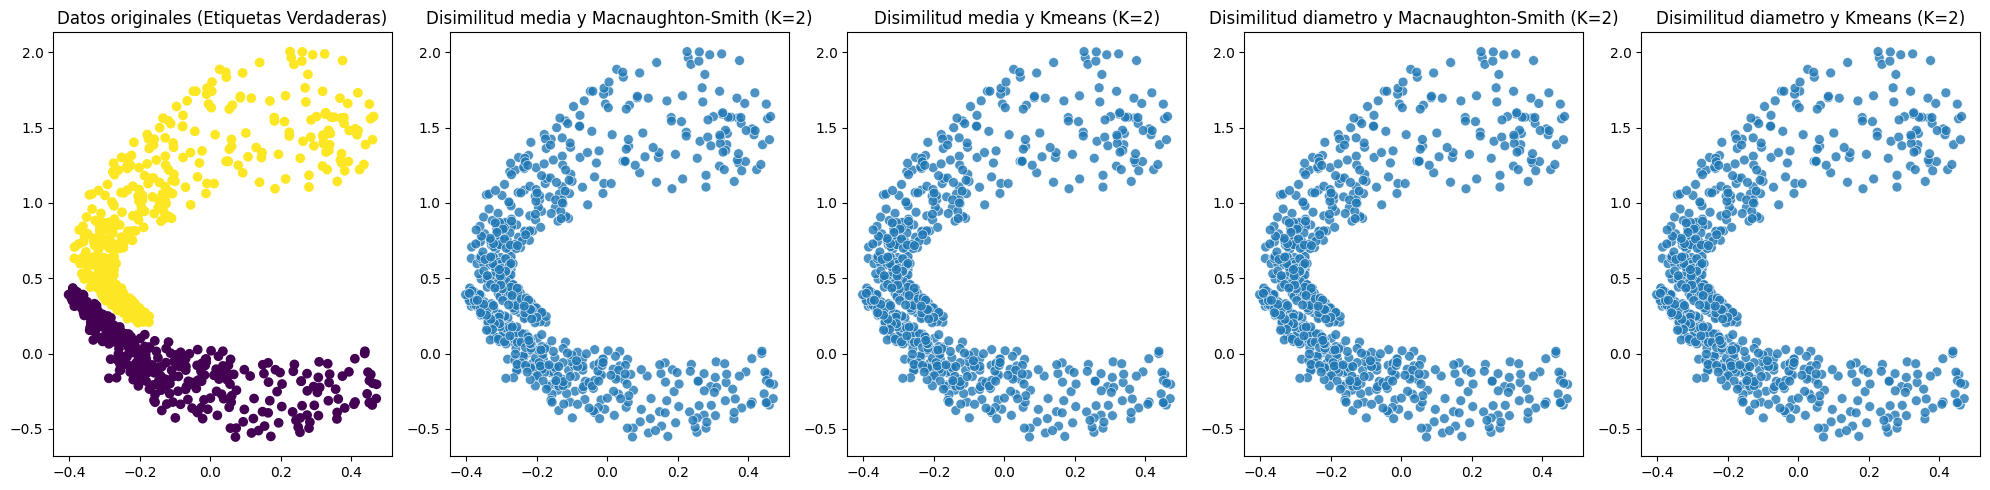

✅ Dataset cargado desde URL GitHub


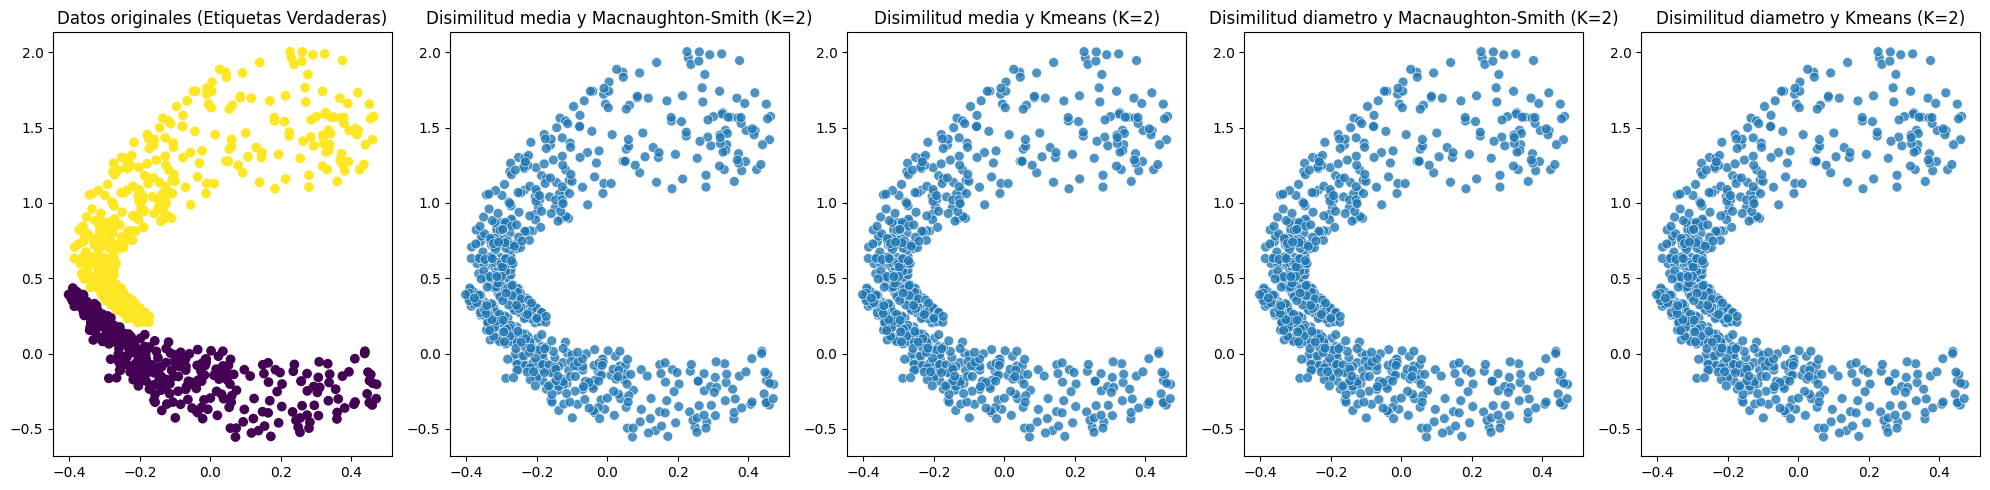

In [66]:
D# Cargar dataset
D =cargar_dataset_csv("dataset_dos_remolinos.csv")
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
Dx = D[:,0:2]
Dy = D[:,2]
plot_varios(Dx,Dy,2)

D# Cargar dataset
D =cargar_dataset_csv("dataset_dos_remolinos.csv")
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
Dx = D[:,0:2]
Dy = D[:,2]
plot_varios(Dx,Dy,2)

In [67]:
def generar_dataset_2d_con_etiquetas(n_muestras=30, seed=42):
    np.random.seed(seed)

    # Crear 3 grupos naturales
    n1 = n_muestras // 3
    n2 = n_muestras // 3
    n3 = n_muestras - n1 - n2

    # Grupo 1: Centro en (2, 2) - Etiqueta 0
    grupo1 = np.random.randn(n1, 2) * 0.5 + np.array([2, 2])
    etiquetas1 = np.zeros(n1, dtype=int)

    # Grupo 2: Centro en (8, 3) - Etiqueta 1
    grupo2 = np.random.randn(n2, 2) * 0.6 + np.array([8, 3])
    etiquetas2 = np.ones(n2, dtype=int)

    # Grupo 3: Centro en (5, 8) - Etiqueta 2
    grupo3 = np.random.randn(n3, 2) * 0.4 + np.array([5, 8])
    etiquetas3 = np.full(n3, 2, dtype=int)

    # Puntos ruidosos/intermedios - Etiqueta 3 (ruido)
    n_ruido = max(2, n_muestras // 10)
    ruido = np.random.rand(n_ruido, 2) * 10
    etiquetas_ruido = np.full(n_ruido, 3, dtype=int)

    # Combinar todos los puntos y etiquetas
    datos = np.vstack([grupo1, grupo2, grupo3, ruido])
    etiquetas = np.concatenate([etiquetas1, etiquetas2, etiquetas3, etiquetas_ruido])

    # Mezclar los puntos y etiquetas manteniendo la correspondencia
    indices_mezclados = np.random.permutation(len(datos))
    datos = datos[indices_mezclados]
    etiquetas = etiquetas[indices_mezclados]

    return datos, etiquetas

In [68]:
Dx, Dy = generar_dataset_2d_con_etiquetas(n_muestras=30, seed=42)

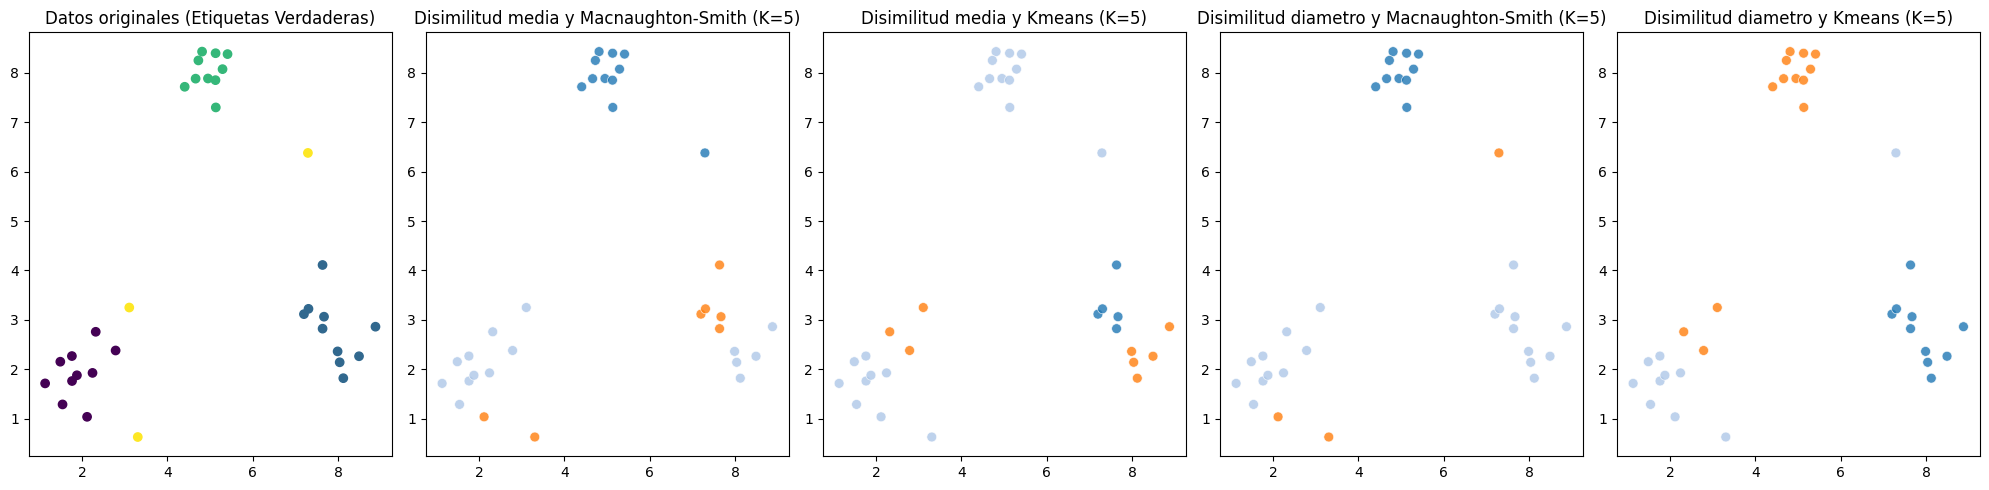

In [69]:
plot_varios(Dx,Dy,5)

# 🚀 ¡TALLER FINALIZADO!"